# Geospatial demand estimation

**Original code:**  [Ariane Millot](https://github.com/ariane-millot), [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Martin J. Stringer](), [Andjelka Kerekes](), [Roberto Heredia]()<br />
**Funding:** Climate Compatible Growth Programme, Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


### Import necessary modules

In [1]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd

# System
import importlib

# Spatial
import geopandas as gpd

# Mapping / Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

In [2]:
import config
importlib.reload(config)

INFO: Successfully loaded configuration for Zambia from config.py.
INFO: Successfully loaded configuration for Zambia from config.py.


<module 'config' from 'C:\\Users\\amillot\\PycharmProjects\\EDeMOS\\config.py'>

In [3]:
# Utility and Data Loading Modules
from utils import processing_raster, finalizing_rasters, spatialjoinvectors
from data_loader import load_initial_data
import plotting
importlib.reload(plotting)
from plotting import *

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

# Part 1. Create base grid with H3

COUNTRY
EPSG:4326
Creating a buffer to ensure full hexagon coverage...
Buffer created successfully.
Clipping hexagons and attaching region attributes...


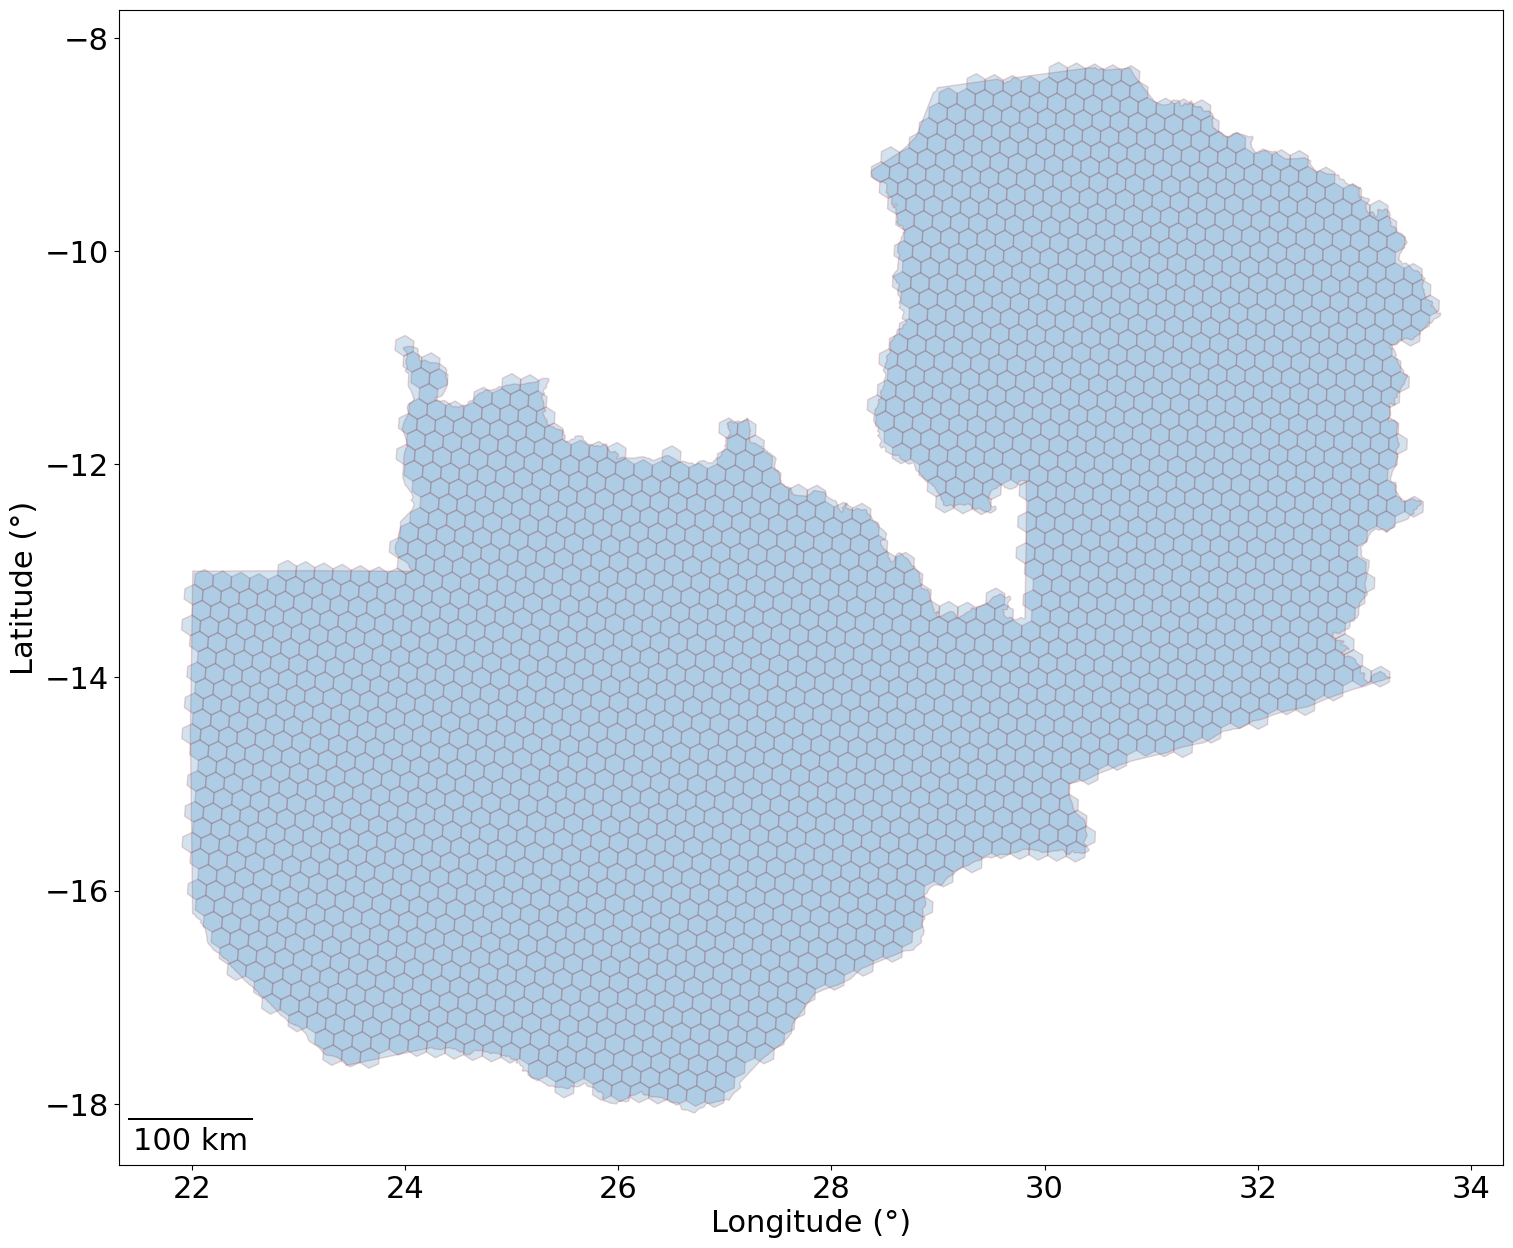

<Figure size 640x480 with 0 Axes>

In [5]:
%run basegridhex.py

# Part 2. Extract GIS-based attributes

## Extract information from vector layers

In [6]:
regions, admin_gdf, region_gdf, grid = load_initial_data(config)

Loading initial data...
Admin boundaries loaded. Country GDF: (1, 3), Region GDF: (10, 12)
Hexagon grid loaded: (2512, 11)
Validating that all regions have cells in the pre-processed grid...
Validation successful: All target regions are present in the grid file.


In [7]:
# transmission lines
mv_lines_gdf = gpd.read_file(config.GRID_PATH / config.MV_LINES_SHP)
hv_lines_gdf = gpd.read_file(config.GRID_PATH / config.HV_LINES_SHP)

# Part 3. Constructing Multi-vector Demand

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial **

where, 

**Residential** = No of HH with access X average en. cons. kWh/HH/year

**Commercial**  = Number of employee X average en. con. kWh/employee

**Industrial**  = Commodity Production (tonnes) from mines X average energy consumption per tonne

In [8]:
extracting_data = True

INFO: Successfully loaded configuration for Zambia from config.py.
Loading initial data...
Admin boundaries loaded. Country GDF: (1, 3), Region GDF: (10, 12)
Hexagon grid loaded: (2512, 11)
Validating that all regions have cells in the pre-processed grid...
Validation successful: All target regions are present in the grid file.
EPSG:4326
Extracting raster data...
EPSG:4326
2025-07-02 16:25:52.775539
Processed WorldPop Buildings Count.
2025-07-02 16:29:19.919503
Processed WorldPop Urban.
2025-07-02 16:48:13.441281
Processed HREA Lighting.
2025-07-02 16:51:33.008318
Processed RWI.
2025-07-02 16:51:52.155520
Processed Falchetta Tiers (Majority).
2025-07-02 16:52:11.741615
Processed Falchetta Tiers (Mean).
Converting features to GeoDataFrame...
2025-07-02 16:52:12.146669
EPSG:4326
Columns after renaming: Index(['geometry', 'h3_index', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'index',
       'NAME_1', 'id', 'buildingssum', 'locationWP', 'HREA', 'rwi',
       'tiers_falchetta_maj', 'tiers_falchet

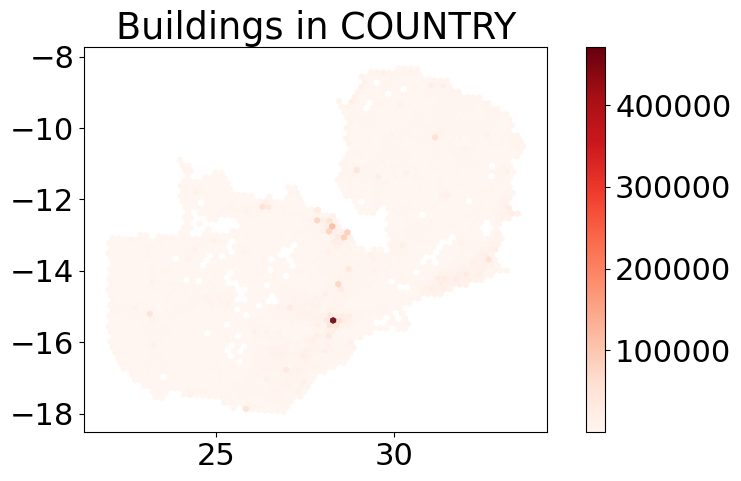

Total number of buildings: 8896504
Plotting HREA map...


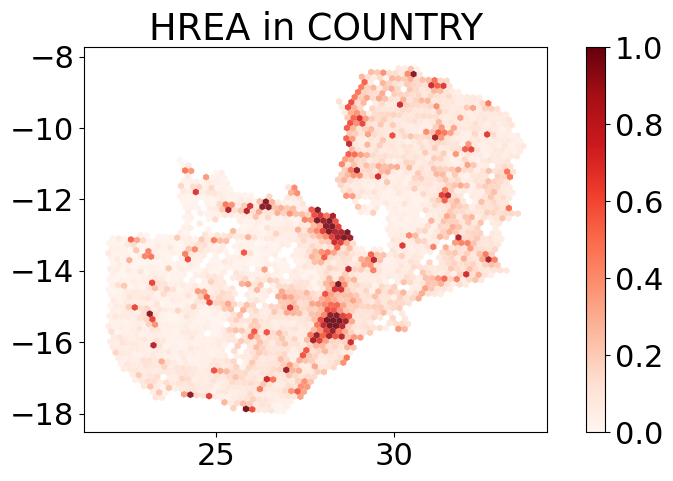

Determining location status (urban/rural)...
'location' column created. Counts: {'rural': 2475, 'urban': 37}
Plotting Urban/Rural map...


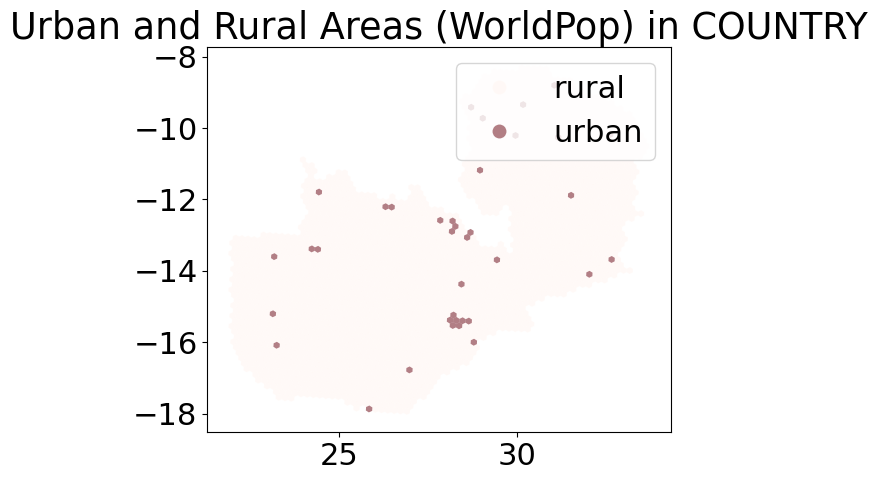

Determining electrification status...
--- Initial Data Sanity Check ---
Grid CRS: EPSG:4326 | Shape: (2512, 18)
Admin Boundary CRS: EPSG:4326 | Shape: (1, 3)
MV Lines CRS: EPSG:4326 | Shape: (64868, 49)
HV Lines CRS: EPSG:4326 | Shape: (931, 63)
Target CRS for all operations: EPSG:32735

--- Projecting all data to target CRS ---
Processing proximity for HV Lines with buffer 500m...
Processing proximity for MV Lines with buffer 500m...
Updated 'is_near_any_line' column. Current counts:
is_near_any_line
False    1737
True      775
Name: count, dtype: int64
'status_electrified' column created. Counts: {'nonelec': 1920, 'elec': 592}
Plotting Line Proximity map...


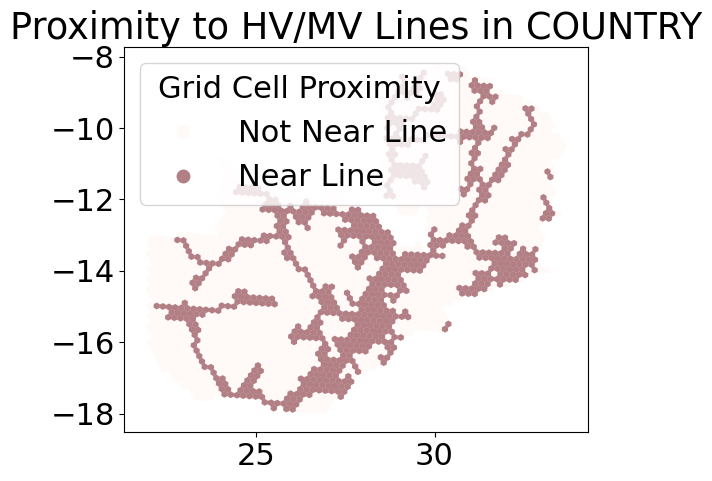

Calculating household numbers...
Total population calculated: 17,798,700
Finished calculating household numbers.
Estimating households with access...
Aggregating HH access data by region...
Total population with access (estimated): 173,667,846
Regional HH summary saved to C:\Users\amillot\PycharmProjects\EDeMOS\Buildings\Outputs\dataHH_region.csv
         accessRateHH accessRateHH_urban accessRateHH_rural
Central          0.39               0.87               0.53
Southern         0.31               0.59               0.43
Eastern          0.13               0.00               0.16
Lusaka           0.84               0.94               4.93
National         0.45               0.78               0.21
Finished estimating households with access.


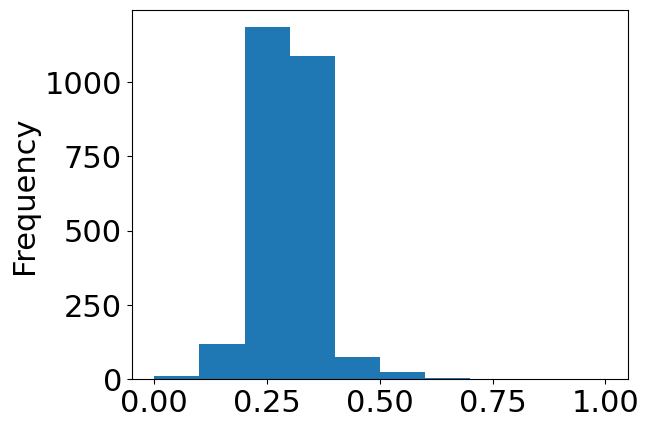

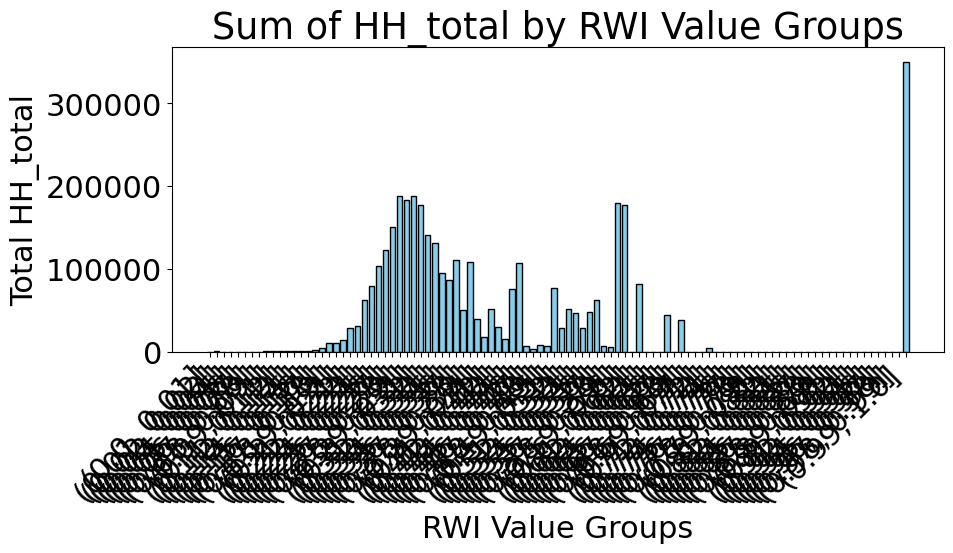

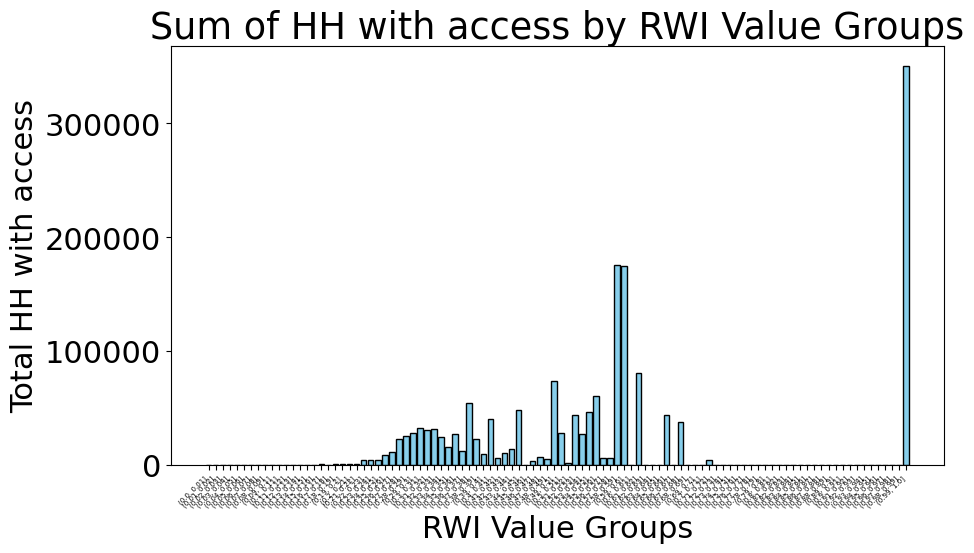

Calculating energy per HH (Method 1: RWI-logistic)...
Solved k for logistic function: 505.0000
Finished calculating energy per HH (Method 1).


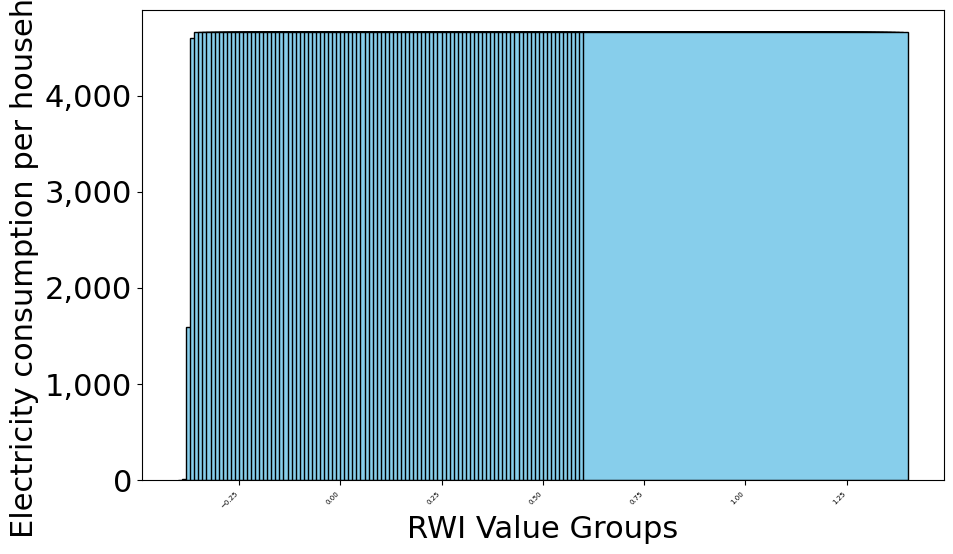

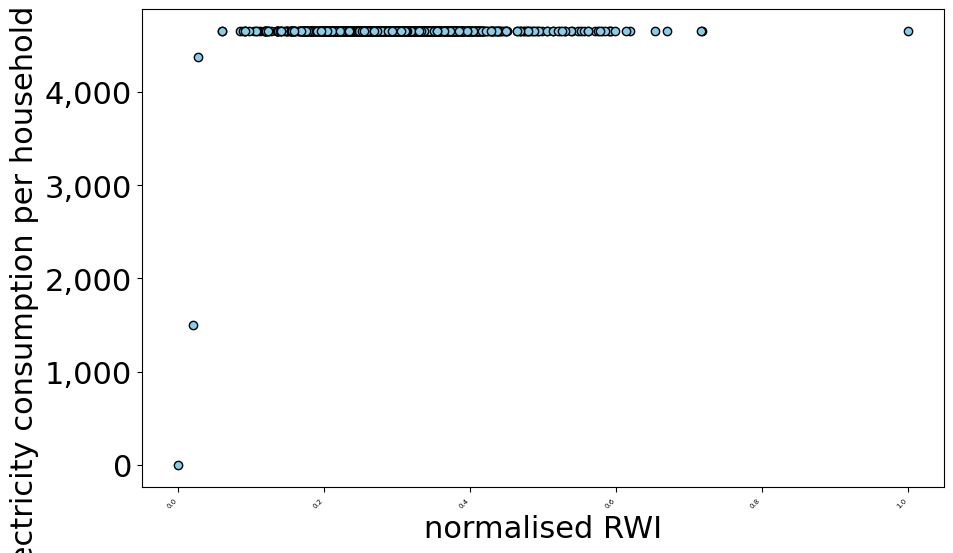

Read data on 12831 survey households
Estimating average energy use per household...
Tier 1 (Electricity,Mobile telephone,Radio) = 11.4 kWh/y
Tier 2 (Television) = 294.8 kWh/y
Tier 3 (Microwave,Washing machine,Computer) = 691.8 kWh/y
Tier 4 (Refrigerator) = 2,258.2 kWh/y
Tier 5 (Air conditioner) = 6,055.1 kWh/y

Applying flexible override rules to adjust tiers...
Written energy use estimates to C:\Users\amillot\PycharmProjects\EDeMOS\Buildings\Data\DHS\Zambia\household_data_Zambia.csv
urban total = 2,281 GWh/year
urban average per household = 1,873 kWh/year
urban min = 0 kWh/year max = 2,763 kWh/year
Created rwi_vs_energy_use_urban.png


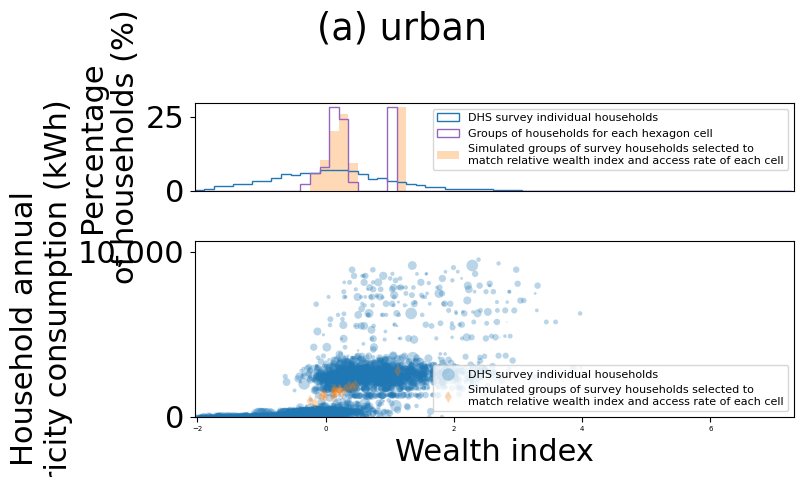

rural total = 27 GWh/year
rural average per household = 61 kWh/year
rural min = 0 kWh/year max = 313 kWh/year
Created rwi_vs_energy_use_rural.png


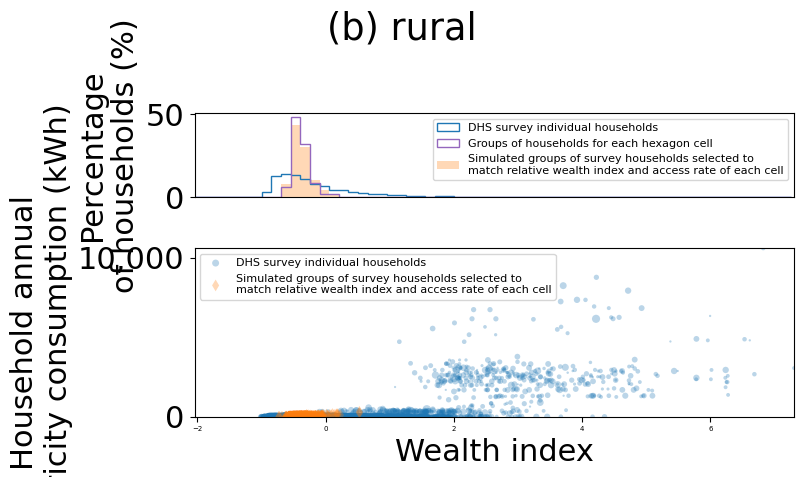

Calculating total residential energy and scaling...
Method meth1: Total Assessed = 7718.16 GWh, UN Stats = 4022.50 GWh, Scaling Factor = 0.5212
Method meth2: Total Assessed = 2268.24 GWh, UN Stats = 4022.50 GWh, Scaling Factor = 1.7734

Summary of energy consumption before scaling (GWh):
                 meth1    meth2
NAME_1                         
Central         717.42   119.98
Copperbelt    2,279.07   658.50
Eastern         283.42     0.90
Luapula         390.63    25.31
Lusaka        2,478.58 1,220.07
Muchinga         68.46     0.41
North-Western   405.49    88.41
Northern        149.61     0.76
Southern        631.27   120.66
Western         314.21    33.25

Summary of energy consumption after scaling (GWh):
                 meth1    meth2
NAME_1                         
Central         373.90   212.77
Copperbelt    1,187.79 1,167.78
Eastern         147.71     1.59
Luapula         203.59    44.88
Lusaka        1,291.77 2,163.67
Muchinga         35.68     0.73
North-Western   211

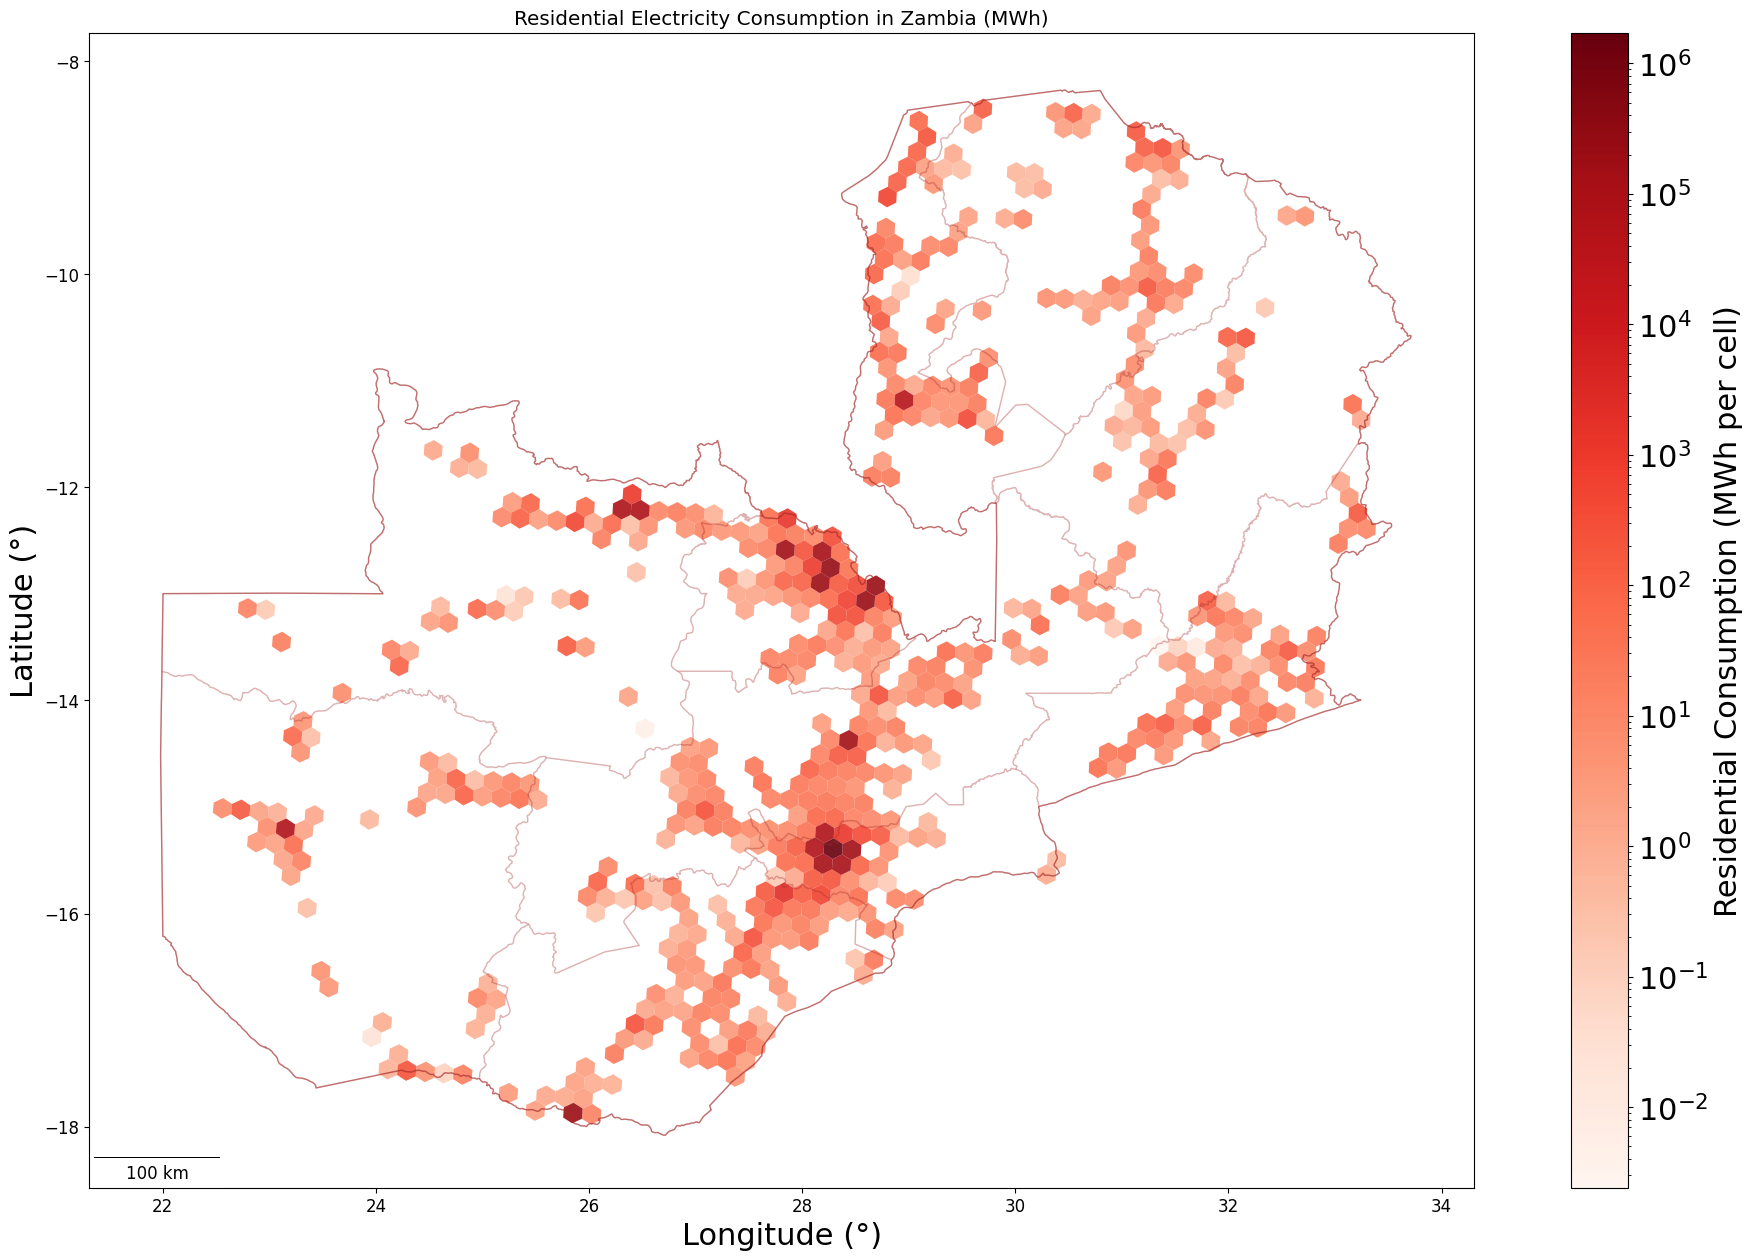

Calculating services electricity (building-based)...
Total services buildings with estimated access: 1,817,872
Service electricity per accessible building: 397 kWh/building
Finished calculating services electricity (building-based).
Calculating services energy (employee-based)...
  Calculating number of men and women (15-49)...
  Calculating number of working men and women...
Total employees with access: 1,931,128
Service electricity per accessible employee: 373.70 kWh/employee
Finished calculating services energy (employee-based).
Plotting Services Consumption map...


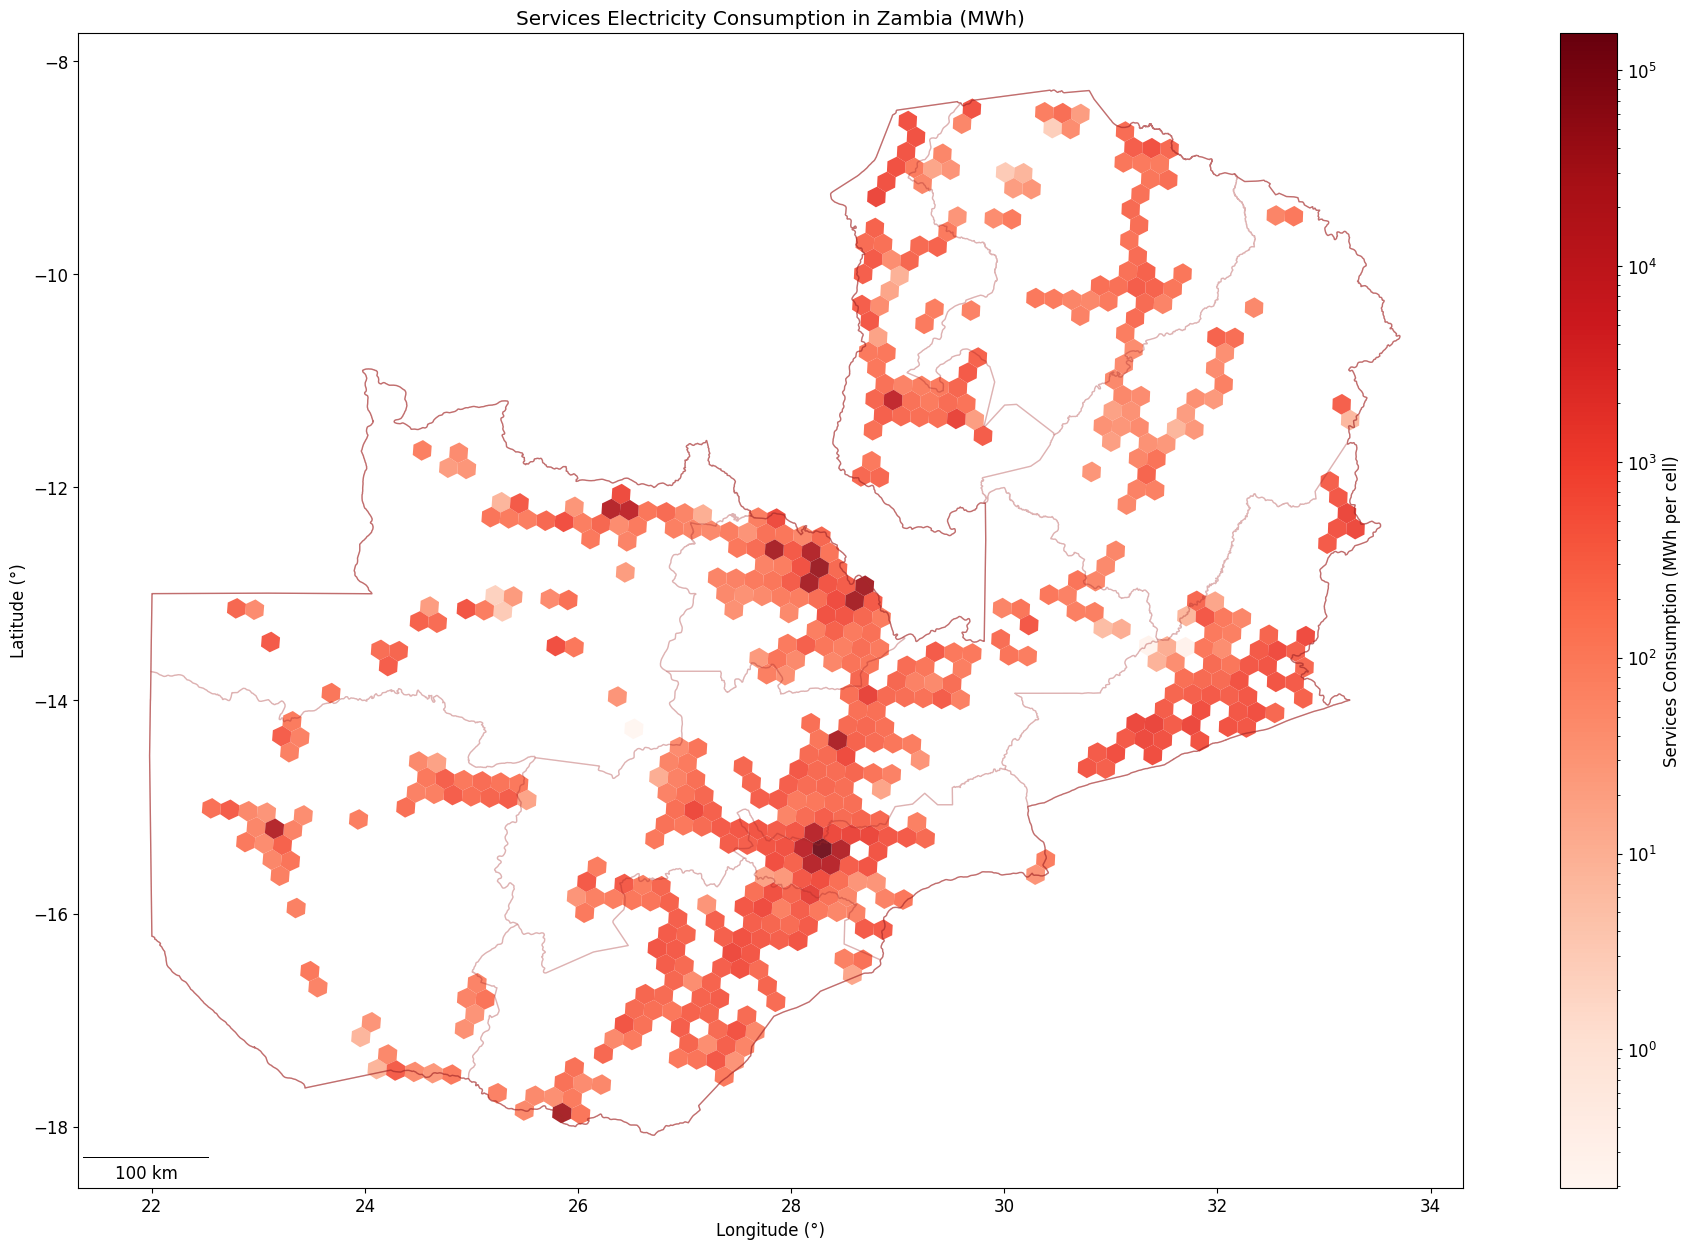

Services electricity consumption assessed after scaling:
Central: 68 GWh
Copperbelt: 208 GWh
Eastern: 33 GWh
Luapula: 28 GWh
Lusaka: 237 GWh
Muchinga: 4 GWh
North-Western: 40 GWh
Northern: 10 GWh
Southern: 65 GWh
Western: 28 GWh
Buildings electricity consumption assessed after scaling:
Central 280,757,918 GWh
Copperbelt 1,375,724,182 GWh
Eastern 34,901,447 GWh
Luapula 73,264,332 GWh
Lusaka 2,401,021,046 GWh
Muchinga 4,558,587 GWh
North-Western 197,068,932 GWh
Northern 11,454,480 GWh
Southern 278,919,306 GWh
Western 86,496,436 GWh


In [9]:
%run Buildings/building_demand.ipynb

In [10]:
total_residential_electricity_assessed = grid[config.COL_RES_ELEC_KWH_METH2].sum()
print("residential electricity consumption:", f"{total_residential_electricity_assessed/10**6:,.0f}","GWh") # GWh

residential electricity consumption: 2,268 GWh


Loading initial data...
Admin boundaries loaded. Country GDF: (1, 3), Region GDF: (10, 12)
Hexagon grid loaded: (2512, 11)
Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mkushi Heap Leach  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mufulira West Heap-Leach Facility  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  TD3a, TD3b, TD5, and TD7 Tailings Dams  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
File C:\Users\amillot\PycharmProjects\EDeMOS\Industry\Data\mines\mineral_facilities_zambia.gpkg exists. Deleting it now...
File deleted

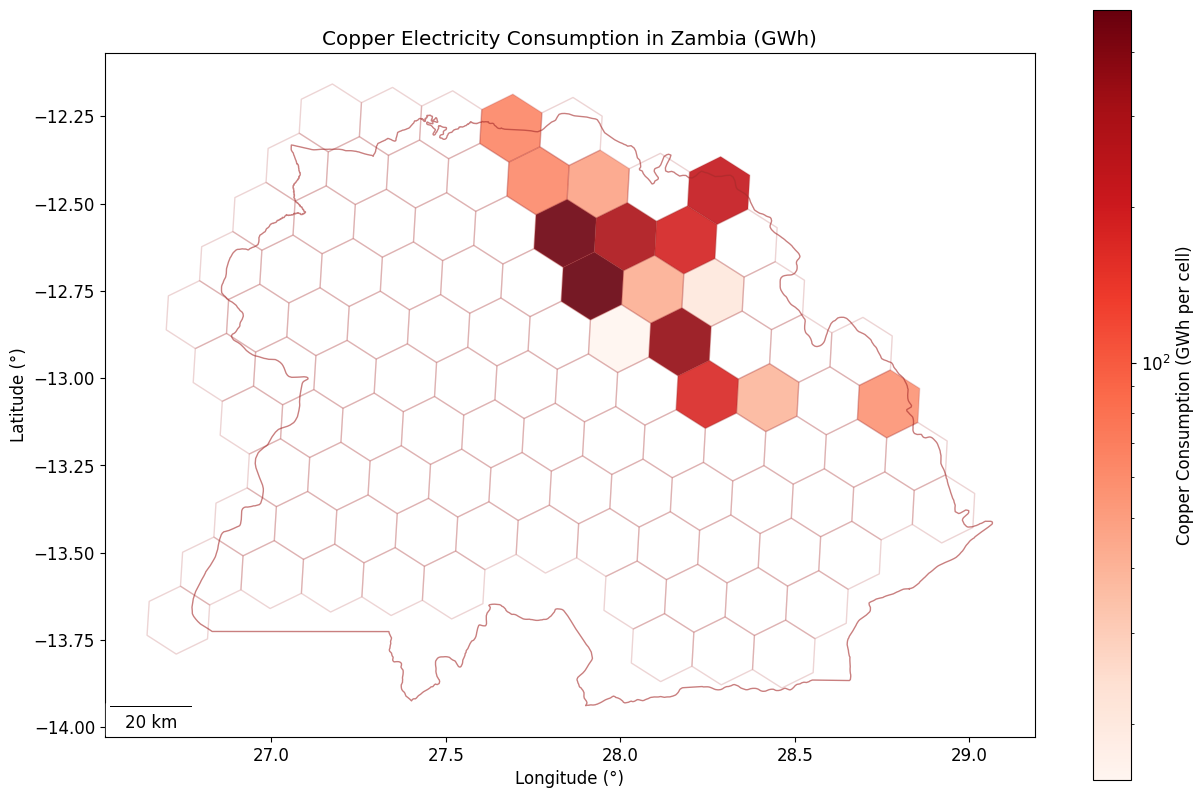

Plotting Copper Region Consumption map...


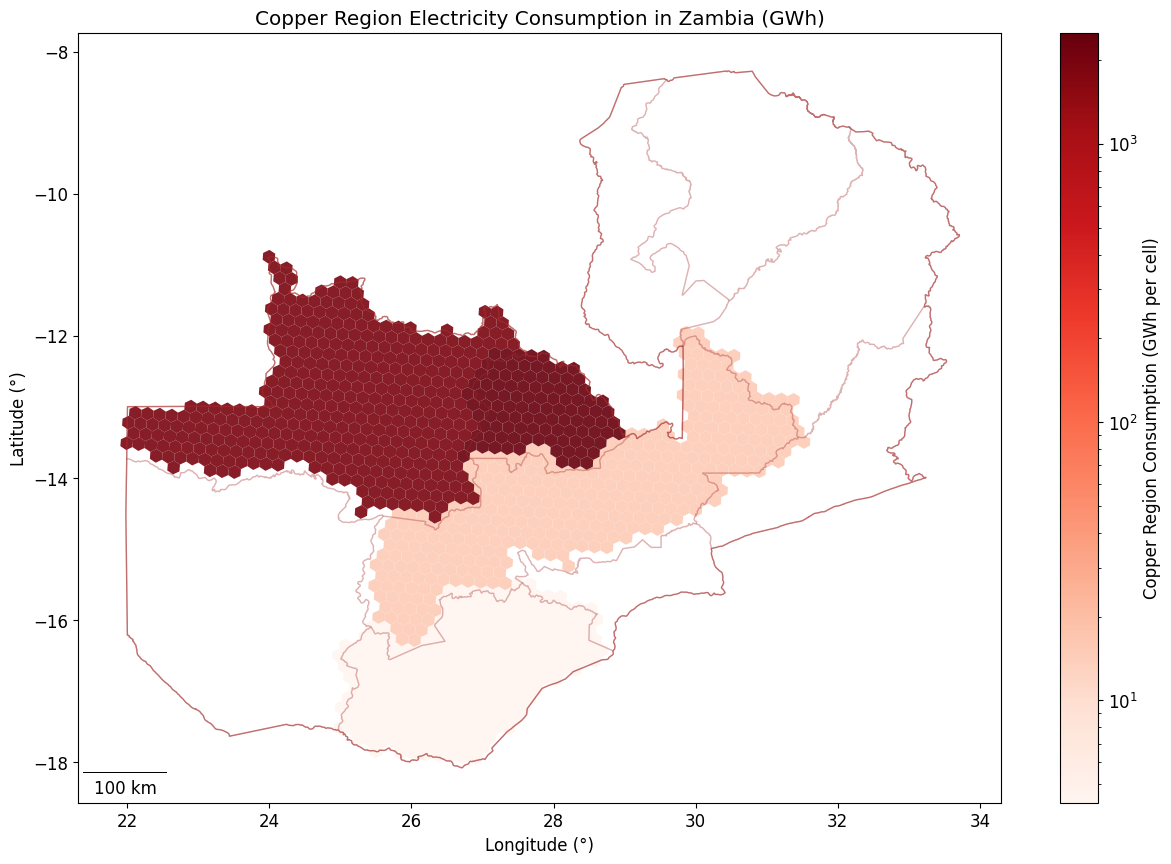

Industry electricity consumption in COUNTRY 5.2 TWh


In [11]:
%run Industry/industry_demand.ipynb
total_industry_electricity_beforescaling_tj = grid[config.COL_IND_ELEC_TJ].sum()
print("Industry electricity consumption in",f"{area}",f"{total_industry_electricity_beforescaling_tj/3600:,.1f}", "TWh")

In [12]:
# Concatenate results
out_path = config.OUTPUT_DIR
grid_buildings = gpd.read_file(config.BUILDINGS_GPKG_FILE) # contains services and residential data
grid_industry = gpd.read_file(config.INDUSTRY_GPKG_FILE)

grid = grid_buildings.copy()
grid = grid.merge(grid_industry, on='id', suffixes=('', '_y'))
grid.drop(grid.filter(regex='_y$').columns, axis=1, inplace=True)
grid.head(2)

h3_index    n0         n1       n2         n3         n4       n5  \
0  859623b3fffffff  2067   577.0000 608.0000 2,050.0000 2,406.0000 220.0000   
1  85960133fffffff   935 1,165.0000 111.0000 1,274.0000 2,127.0000 730.0000   

   index      NAME_1  id  ...  nb_men_working  total_employee  \
0      0      Lusaka   1  ...         79.7216        119.7246   
1      1  Copperbelt   2  ...         94.5951        152.3924   

   total_employee_withaccess  ser_elec_kWh_emp  SElec_kWh_weighted  \
0                   119.7246       44,741.3316         44,741.3316   
1                   152.3924       56,949.3423         56,949.3423   

   ser_elec_kWh_final                                           geometry  \
0         44,741.3316  POLYGON ((28.70901 -15.75321, 28.61883 -15.797...   
1         56,949.3423  POLYGON ((27.54588 -13.20336, 27.45649 -13.247...   

   ind_elec_TJ copper_elec_TJ  ind_elec_scaled_TJ  
0          NaN            NaN                 NaN  
1          NaN            NaN                 NaN  

[2 rows x 72 columns]

In [13]:
# Units
grid[config.COL_IND_ELEC_GWH]=grid[config.COL_IND_ELEC_SCALED_TJ]/3.6
grid[config.COL_IND_ELEC_KWH]=grid[config.COL_IND_ELEC_GWH] * 10**6
total_ind_electricity_gwh = grid[config.COL_IND_ELEC_GWH].sum()
print(f"Industry: {total_ind_electricity_gwh:,.0f}", "GWh")
grid[config.COL_RES_ELEC_KWH_FINAL] = grid[config.COL_RES_ELEC_KWH_METH2_SCALED]
total_res_electricity_gwh = grid[config.COL_RES_ELEC_KWH_FINAL].sum() / 10**6
print(f"Residential: {total_res_electricity_gwh:,.0f}", "GWh")
total_ser_electricity_gwh = grid[config.COL_SER_ELEC_KWH_FINAL].sum() / 10**6
print(f"Services: {total_ser_electricity_gwh:,.0f}", "GWh")

Industry: 6,587 GWh
Residential: 4,023 GWh
Services: 722 GWh


In [14]:
grid[config.COL_TOTAL_ELEC_KWH] = grid.apply(lambda row: (np.nansum([row[config.COL_RES_ELEC_KWH_FINAL], 
                                          row[config.COL_SER_ELEC_KWH_FINAL],  
                                             row[config.COL_IND_ELEC_KWH]
                                                     ])), axis=1)
total_elec_gwh = grid[config.COL_TOTAL_ELEC_KWH].sum() / 10**6
print("total electricity consumption:", f"{total_elec_gwh:,.0f}","GWh") 

total electricity consumption: 11,332 GWh


### Export result

In [15]:
grid.to_file(config.TOTAL_ELECTRICITY_GPKG_FILE, driver="GPKG", index=False, engine='fiona')

## Print maps for quick assessment

### Total demand map

Plotting Total Consumption map...


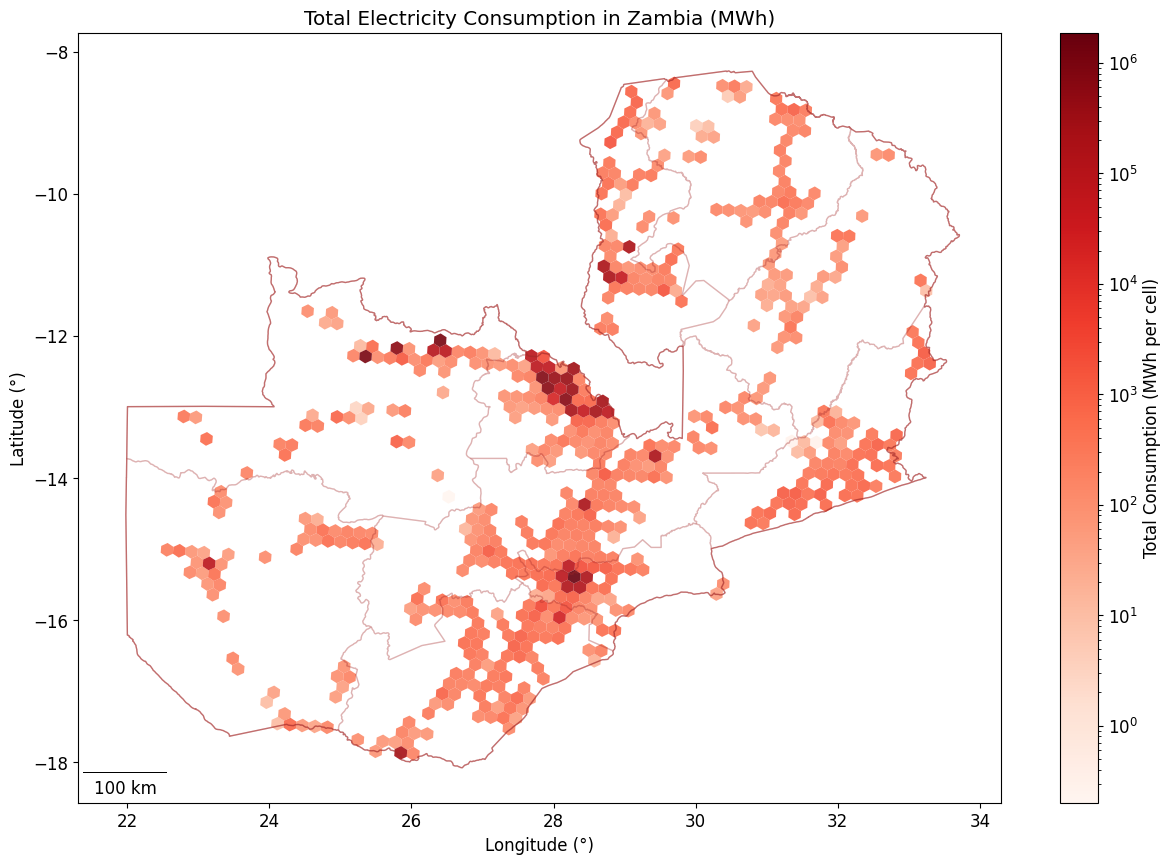

In [16]:
plot_sector_consumption_map(grid, config.COL_TOTAL_ELEC_KWH, config, admin_gdf, region_gdf, 'Total',
                           fig_size=(15, 10))

### Residential map

Plotting Residential Consumption map...


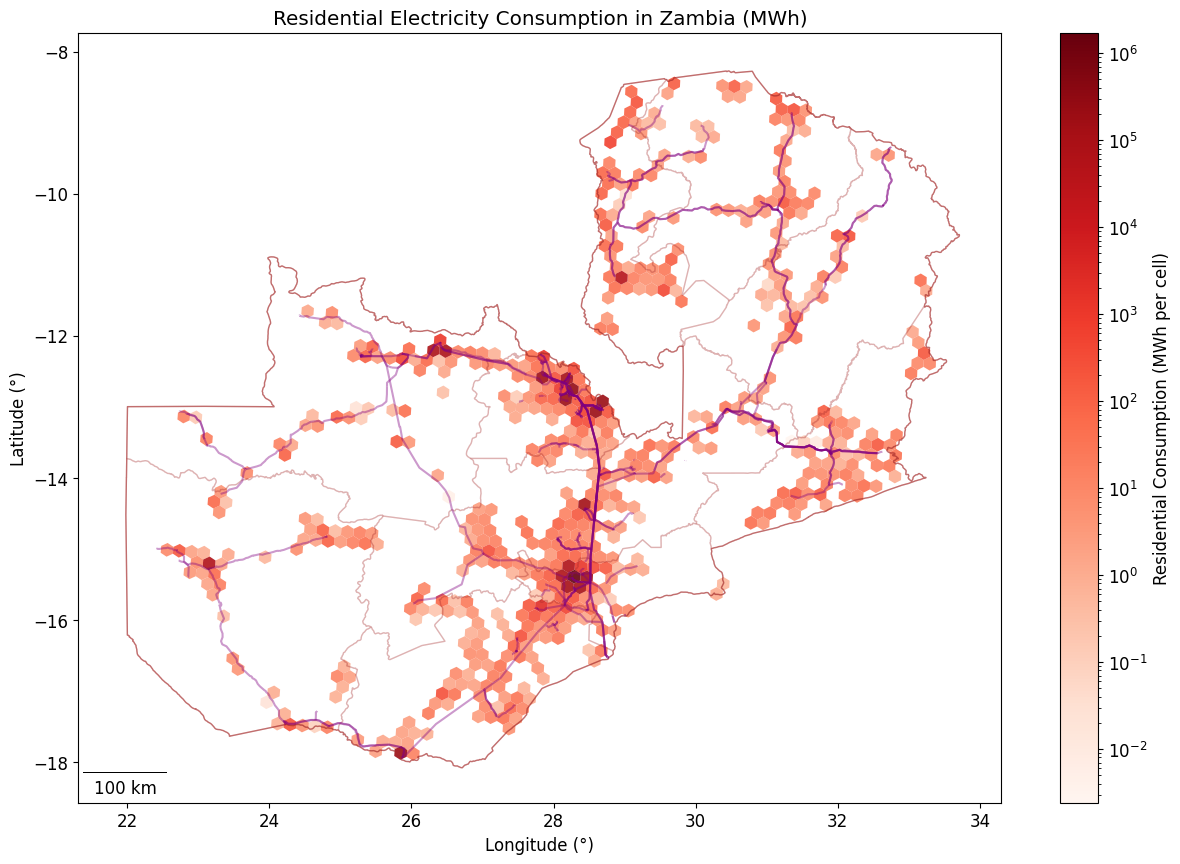

In [17]:
plot_sector_consumption_map(grid, config.COL_RES_ELEC_KWH_FINAL, config, admin_gdf, region_gdf, 'Residential', lines_gdf=hv_lines_gdf, 
                           fig_size=(15, 10))

### Services map

Plotting Services Consumption map...


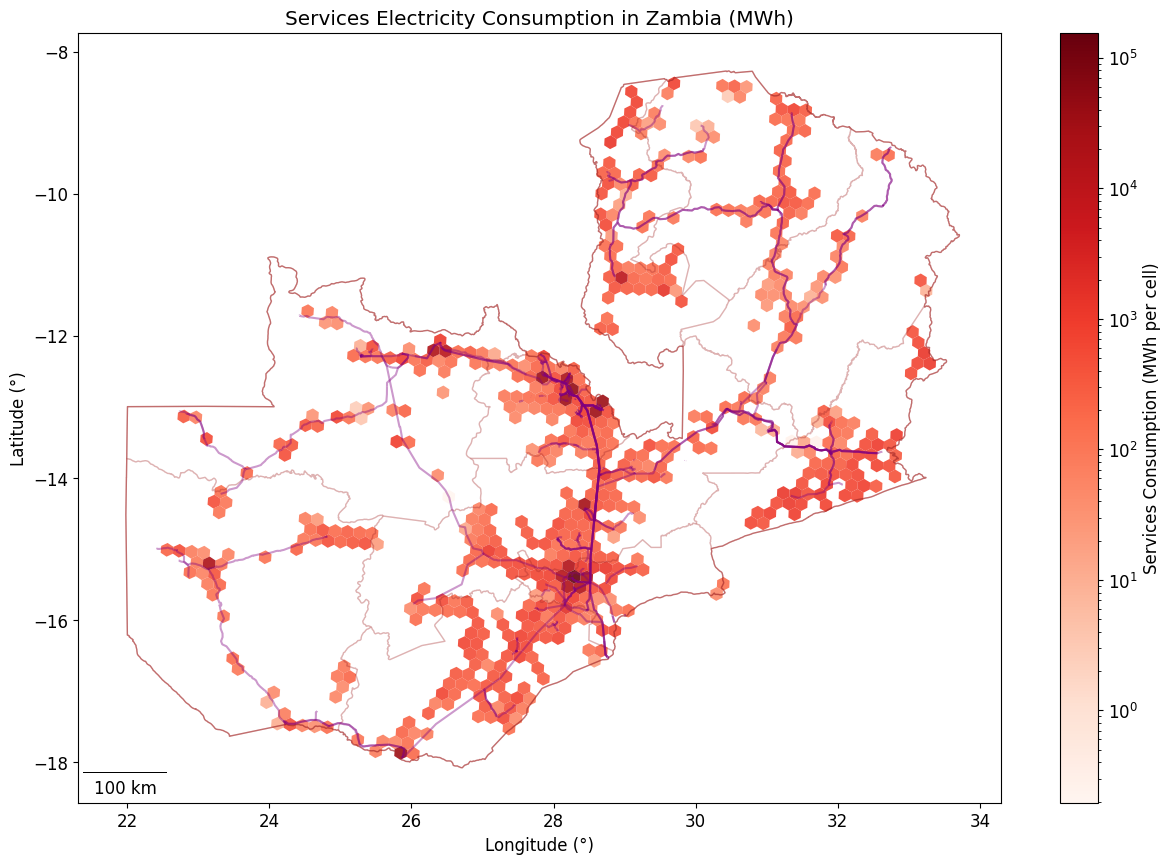

In [18]:
plot_sector_consumption_map(grid, config.COL_SER_ELEC_KWH_FINAL, config, admin_gdf, region_gdf, 'Services', lines_gdf=hv_lines_gdf, 
                           fig_size=(15, 10))

### Buildings map

In [19]:
plot_sector_consumption_map(grid, config.COL_BUI_ELEC_KWH_FINAL, config, admin_gdf, region_gdf,  'Buildings', lines_gdf=hv_lines_gdf,
                           fig_size=(15, 10))

Plotting Buildings Consumption map...


### Industry map

Plotting Industry Consumption map...


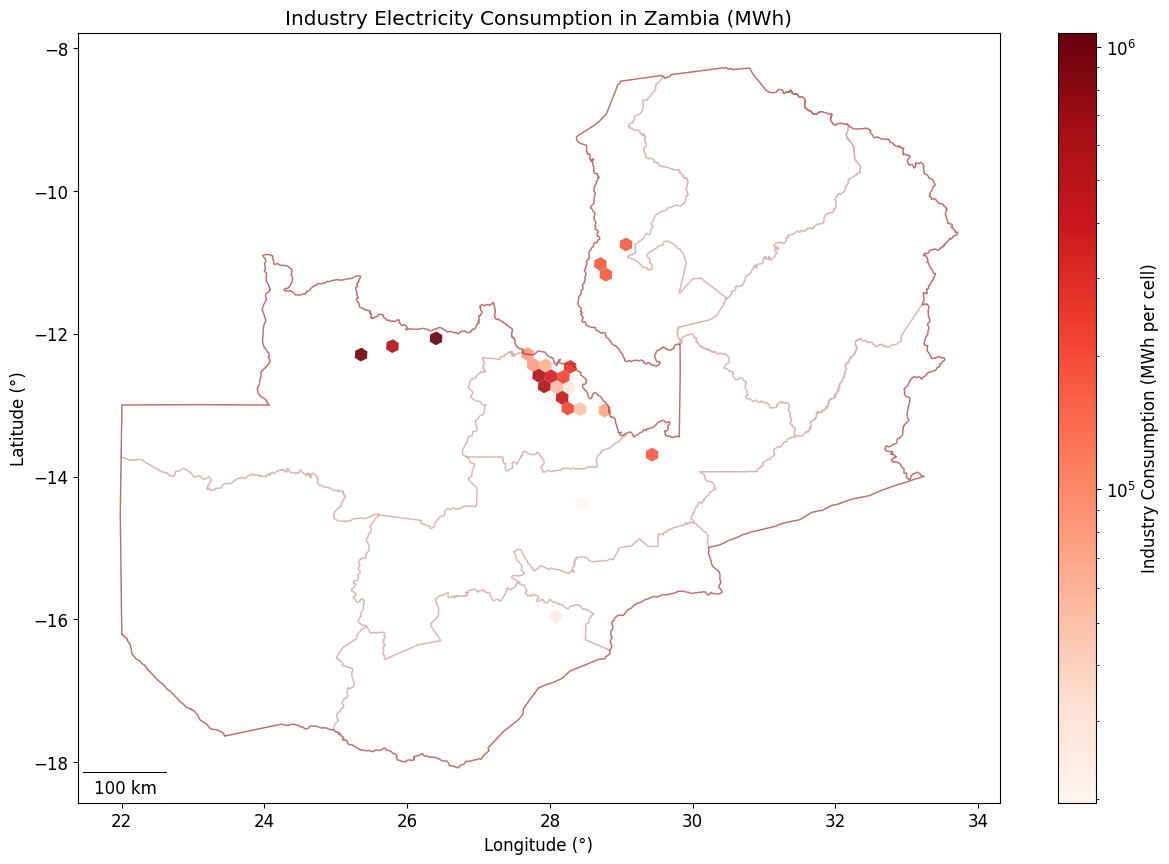

In [20]:
plot_sector_consumption_map(grid, config.COL_IND_ELEC_KWH, config, admin_gdf, region_gdf, 'Industry', lines_gdf=None, 
                           fig_size=(15, 10))

In [21]:
total_industry_elec_perregion_gwh=grid.groupby(config.COL_ADMIN_NAME)[config.COL_IND_ELEC_GWH].sum()
total_industry_elec_perregion_gwh

NAME_1
Central           198.5864
Copperbelt      3,180.9165
Eastern             0.0000
Luapula           537.0055
Lusaka              0.0000
Muchinga            0.0000
North-Western   2,646.6168
Northern            0.0000
Southern           24.3748
Western             0.0000
Name: ind_elec_GWh, dtype: float64

In [22]:
grid['total_industry_elec_perregion_gwh'] = grid[config.COL_ADMIN_NAME].map(total_industry_elec_perregion_gwh)

Plotting Industry Region Consumption map...


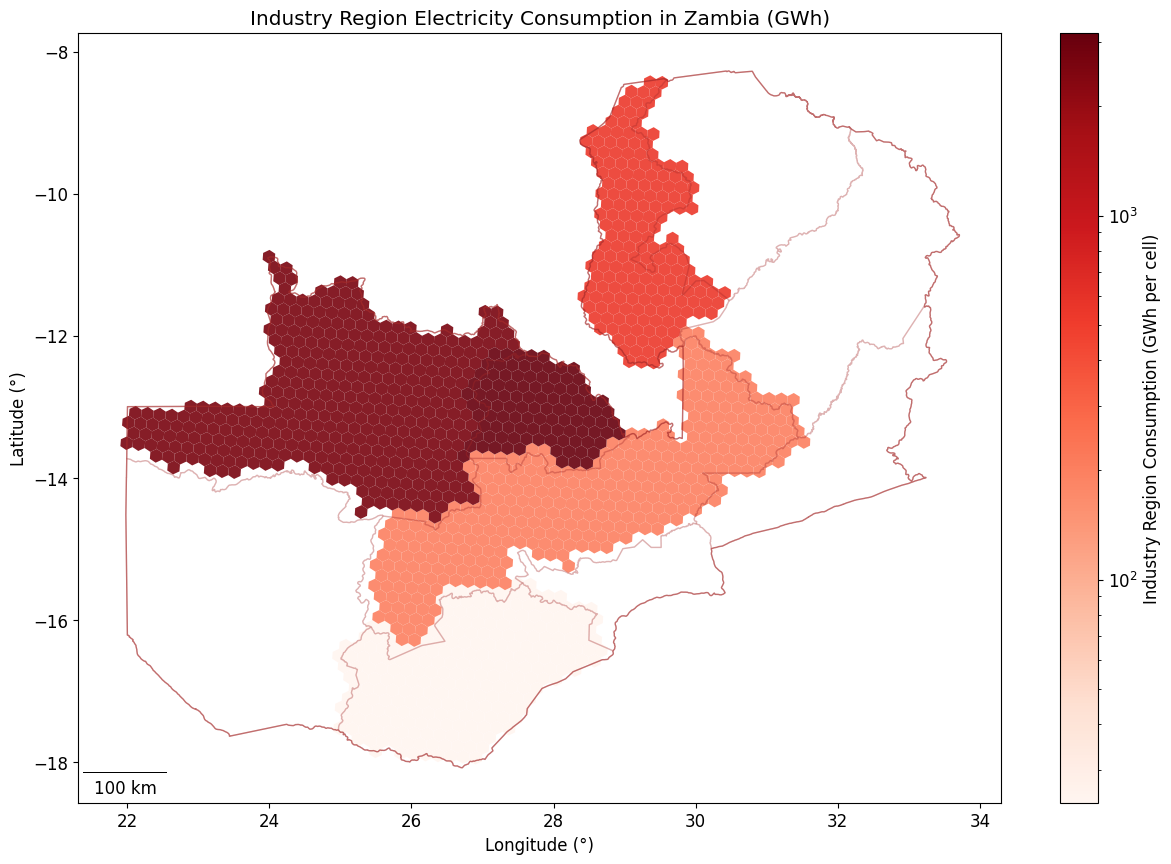

In [23]:
plot_sector_consumption_map(grid, 'total_industry_elec_perregion_gwh', config, admin_gdf, region_gdf, 'Industry Region', lines_gdf=None, 
                           fig_size=(15, 10))